## Important Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import pytz

## Set time to a certain number of years

In [2]:
years = 5
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

# Create a list of tickers

In [3]:
tickers = ["M&M.NS","HDFCBANK.NS", "ITC.NS","SUNPHARMA.NS","TATASTEEL.NS",
             "INFY.NS","DLF.NS"]

## Daily Adjusted close Price

In [4]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data["Adj Close"]
print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                 M&M.NS  HDFCBANK.NS      ITC.NS  SUNPHARMA.NS  TATASTEEL.NS  \
Date                                                                           
2019-01-04   690.260986  1021.594788  232.847397    413.032928     41.629742   
2019-01-07   694.018677  1023.138672  233.427505    410.176514     41.446198   
2019-01-08   688.168213  1014.623047  235.582367    426.600739     41.945602   
2019-01-09   690.926880  1021.281189  240.679398    427.267212     40.908371   
2019-01-10   697.490906  1017.276733 

## Calculate the daily log returns

In [5]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

              M&M.NS  HDFCBANK.NS    ITC.NS  SUNPHARMA.NS  TATASTEEL.NS  \
Date                                                                      
2019-01-07  0.005429     0.001510  0.002488     -0.006940     -0.004419   
2019-01-08 -0.008466    -0.008358  0.009189      0.039261      0.011977   
2019-01-09  0.004001     0.006541  0.021405      0.001561     -0.025039   
2019-01-10  0.009455    -0.003929 -0.002759     -0.009291      0.002501   
2019-01-11 -0.007255     0.001611  0.019661     -0.000450     -0.012990   
...              ...          ...       ...           ...           ...   
2023-12-27  0.015343     0.012317  0.001423      0.003960      0.014685   
2023-12-28  0.027176     0.001144  0.015198      0.007715      0.006900   
2023-12-29 -0.002916     0.002343 -0.004319     -0.002142      0.010441   
2024-01-01 -0.015207    -0.006545  0.012794      0.000635      0.001789   
2024-01-02 -0.028042     0.000589  0.004902      0.028127     -0.001789   

             INFY.NS    

## Create an equally weighted portfolio

In [6]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]


## Calculate the historical portfolio returns

In [7]:
historical_returns = (log_returns*weights).sum(axis = 1)
print(historical_returns)

Date
2019-01-07    0.005751
2019-01-08    0.007222
2019-01-09    0.002965
2019-01-10    0.001317
2019-01-11   -0.000215
                ...   
2023-12-27    0.010059
2023-12-28    0.009515
2023-12-29   -0.001772
2024-01-01   -0.000705
2024-01-02   -0.002966
Length: 1233, dtype: float64


## Find the X- day historical return

In [8]:
days = 252
historical_x_day_returns =  historical_returns.rolling( window = days).sum()

## Create a covariance matrix for all the securities

In [9]:
cov_matrix = log_returns.cov() * 252

## Calculate portfolio Standard Deviation

In [10]:
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

## Set differnt confindence levels to visualize

In [11]:
confidence_levels = [0.9,0.95,0.99]

## Calculate VaR at differnt confindence levels

In [12]:
VaRs = []

for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

## Print out VaR Results

In [13]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $-475,985.74
    95%:          $-554,073.34
    99%:          $-700,552.70


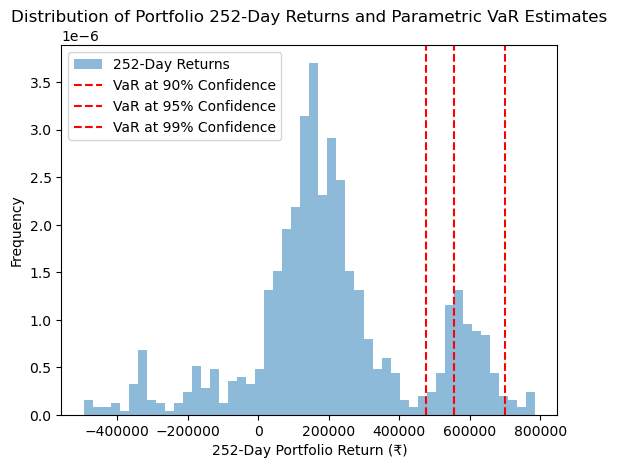

In [14]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_rupees = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_rupees, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return (₹)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()